# Leer datasets

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)
wine = wine.frame
wine.drop(columns=['target'], inplace=True)
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# Realizamos los clusters

In [3]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 3
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.9, min_samples=3),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(wine)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(wine)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        if len(np.unique(labels)) > 1:
            results[name] = labels
            print(f"{name}: {np.unique(labels, return_counts=True)}")
    except Exception as e:
        print(f"Error with {name}: {e}")

KMeans: (array([0, 1, 2], dtype=int32), array([102,  49,  27]))
AgglomerativeClustering: (array([0, 1, 2]), array([48, 72, 58]))


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine)
for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for min_samples in [3, 4, 5, 6]:
        for metric in ['euclidean', 'manhattan']:
            #printeamos numero de labels
            c= DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            c.fit(wine_scaled)
            if len(np.unique(c.labels_))>1:
                print(np.unique(c.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([102,  49,  27]))
(array([-1]), array([178]))
(array([0, 1, 2]), array([48, 72, 58]))


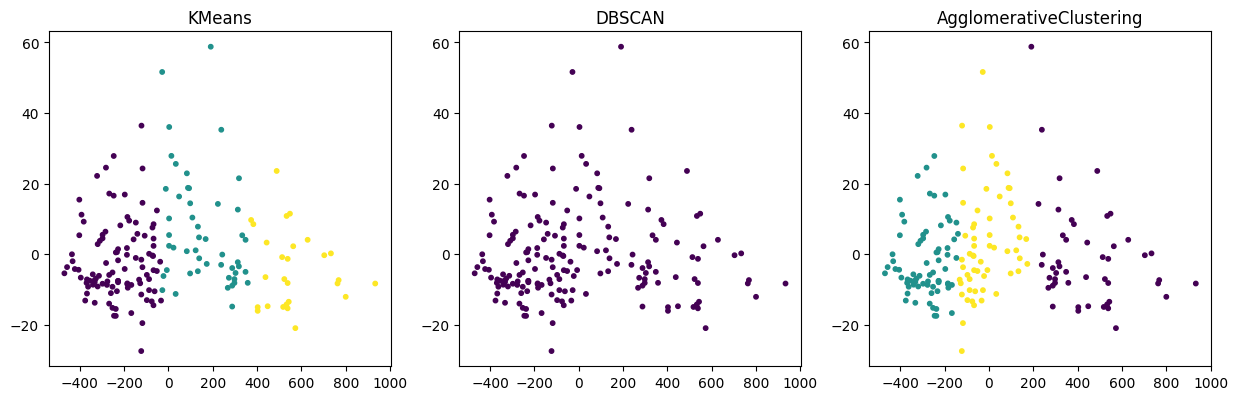

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    print(np.unique(labels, return_counts=True))
    plt.subplot(4, 3, i)
    plt.scatter(wine_pca[:, 0], wine_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [14]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [15]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(wine, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.559582,497.004876,0.549558,0.419006,0.058388,0.856226
AgglomerativeClustering,0.564480,552.851712,0.535734,0.309342,0.111207,0.858922


In [17]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
AgglomerativeClustering,0.564480,552.851712,0.535734,0.309342,0.111207,0.858922,0.360237
KMeans,0.559582,497.004876,0.549558,0.419006,0.058388,0.856226,0.353579


# Interpretar

In [18]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

Processing AgglomerativeClustering with 3 clusters
Ripper Accuracy for AgglomerativeClustering: 0.97
Ripper Rules:

Reglas para clase: 0
[[proline=1032.0-1194.5] V [proline=>1194.5] V [proline=865.5-1032.0^malic_acid=1.67-1.73] V [total_phenols=2.31-2.5^proline=865.5-1032.0]]

Reglas para clase: 1
[[proline=473.6-520.0] V [proline=<410.5] V [proline=410.5-473.6] V [proline=520.0-594.0]]

Reglas para clase: 2
[[proline=660.0-723.0] V [proline=723.0-865.5] V [proline=594.0-660.0] V [proline=865.5-1032.0^magnesium=105.0-111.0]]
Decision Tree Accuracy for AgglomerativeClustering: 1.00


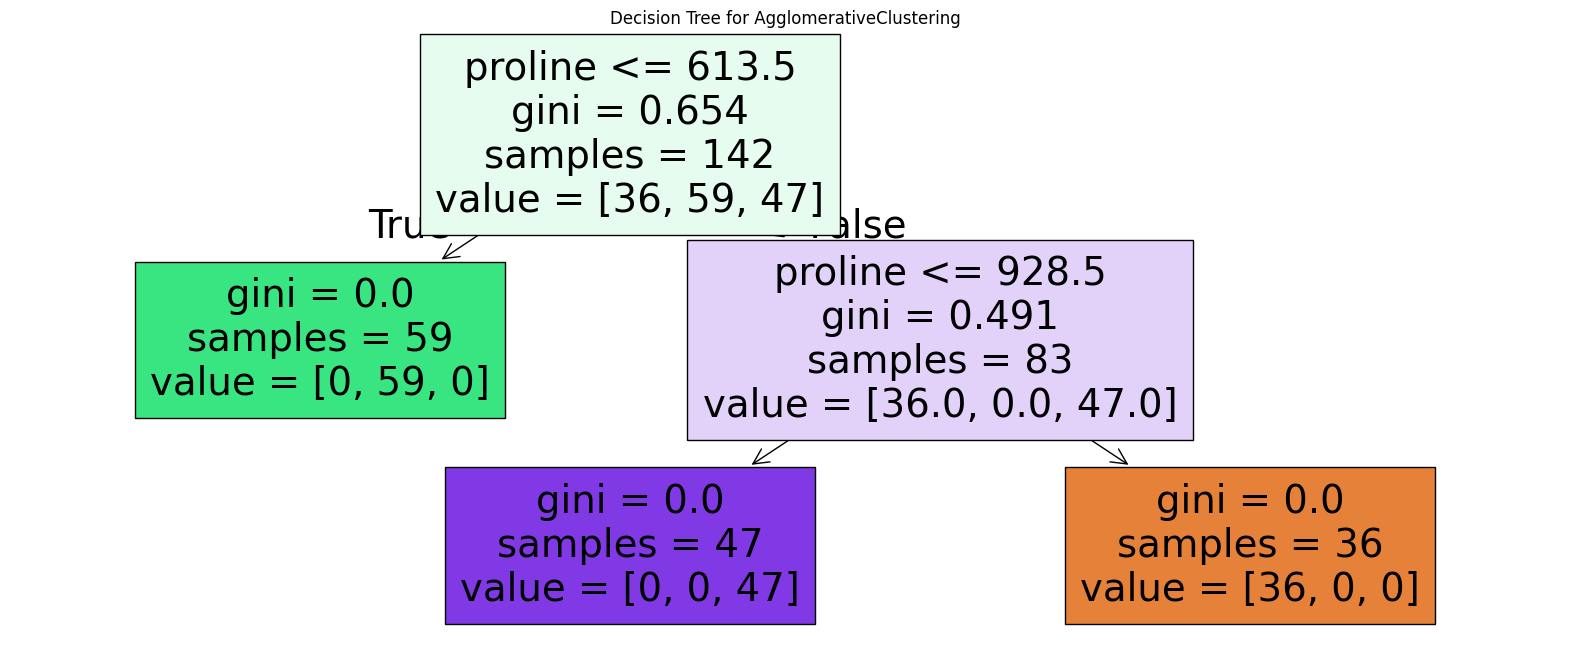

Optimization started

Training time: 5.51s, epochs: 200

Least training loss reached: 0.031
DSGD Accuracy for AgglomerativeClustering: 0.83
DSGD Rules:


Most important rules for class 0

	[0.747] R39: color_intensity > 6.624
			0: 0.612	1: 0.000	2: 0.302	Unc: 0.086

	[0.688] R51: proline > 938.089
			0: 0.688	1: 0.000	2: 0.000	Unc: 0.312

	[0.579] R43: hue > 1.114
			0: 0.554	1: 0.052	2: 0.000	Unc: 0.394

	[0.546] R19: magnesium > 110.291
			0: 0.431	1: 0.005	2: 0.256	Unc: 0.307

	[0.544] R17: 90.597 < magnesium < 100.444
			0: 0.544	1: 0.000	2: 0.000	Unc: 0.456

	[0.515] R26: 2.002 < flavanoids < 2.677
			0: 0.362	1: 0.370	2: 0.000	Unc: 0.267

	[0.475] R18: 100.444 < magnesium < 110.291
			0: 0.356	1: 0.009	2: 0.268	Unc: 0.366

	[0.451] R3: alcohol > 13.530
			0: 0.427	1: 0.049	2: 0.000	Unc: 0.524

	[0.446] R12: alcalinity_of_ash < 17.151
			0: 0.289	1: 0.000	2: 0.399	Unc: 0.312

	[0.444] R13: 17.151 < alcalinity_of_ash < 19.473
			0: 0.259	1: 0.000	2: 0.502	Unc: 0.239

	[0.443] R42:

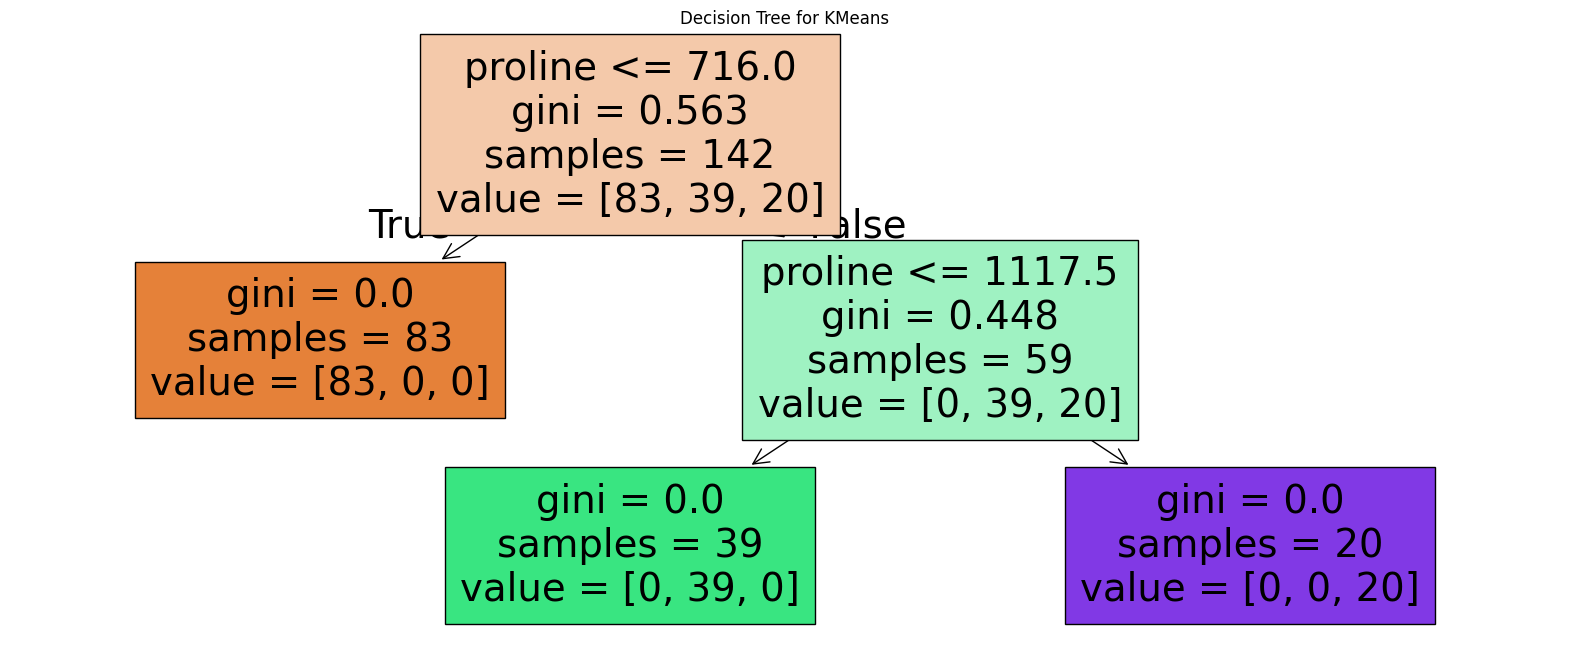

Optimization started

Training time: 5.46s, epochs: 200

Least training loss reached: 0.037
DSGD Accuracy for KMeans: 0.75
DSGD Rules:


Most important rules for class 0

	[0.679] R48: proline < 531.699
			0: 0.679	1: 0.000	2: 0.000	Unc: 0.321

	[0.641] R8: ash < 2.173
			0: 0.493	1: 0.340	2: 0.000	Unc: 0.166

	[0.603] R34: 1.608 < proanthocyanins < 2.000
			0: 0.481	1: 0.276	2: 0.000	Unc: 0.243

	[0.592] R49: 531.699 < proline < 734.894
			0: 0.592	1: 0.000	2: 0.000	Unc: 0.408

	[0.543] R28: nonflavanoid_phenols < 0.282
			0: 0.452	1: 0.199	2: 0.000	Unc: 0.349

	[0.507] R16: magnesium < 90.597
			0: 0.507	1: 0.000	2: 0.000	Unc: 0.493

	[0.500] R41: 0.799 < hue < 0.956
			0: 0.500	1: 0.000	2: 0.000	Unc: 0.500

	[0.483] R37: 3.491 < color_intensity < 5.058
			0: 0.328	1: 0.385	2: 0.000	Unc: 0.287

	[0.479] R15: alcalinity_of_ash > 21.795
			0: 0.371	1: 0.248	2: 0.000	Unc: 0.381

	[0.471] R25: 1.327 < flavanoids < 2.002
			0: 0.471	1: 0.000	2: 0.000	Unc: 0.529

	[0.469] R44: od280/od315_

In [ ]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = wine.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    print('Ripper Rules:')
    ripper.print_rules()
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    plt.figure(figsize=(20, 8))
    sk_tree.plot_tree(dtree, filled=True, feature_names=X_train.columns)
    plt.title(f'Decision Tree for {name}')
    plt.show()
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    max_label = np.max(labels)
    y_train = np.where(y_train == -1, max_label + 1, y_train)
    y_test = np.where(y_test == -1, max_label + 1, y_test)
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    print('DSGD Rules:')
    ds.print_most_important_rules(threshold=0.32)
    saved_models[name]['ds'] = ds
    
    print('--' * 40)
